<a href="https://colab.research.google.com/github/mohityadav11a/asteroid_spectra/blob/main/8_dense_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 8. Deep Learning - A Dense Network

Now it's time for me to start using Keras to move on to the next step: applying neural network architectures to our spectral data.



In [ ]:
# Importing libraries
import os
import numpy as np
import pandas as pd
import sklearn
from sklearn import preprocessing

In [ ]:
# Mount the Google Drive
try:
    from google.colab import drive
    drive.mount('/gdrive')
    core_path = "/gdrive/MyDrive/colab/asteroid_taxonomy/"
except ModuleNotFoundError:
    core_path = ""

Mounted at /gdrive


In [ ]:
# Loading level 2 asteroid data
asteroids_df = pd.read_pickle(os.path.join(core_path, "data/lvl2/", "asteroids.pkl"))

In [ ]:
# Allocate the spectra to one array and the classes to another one
asteroids_X = np.array([k["Reflectance_norm550nm"].tolist() for k in asteroids_df["SpectrumDF"]])
asteroids_y = np.array(asteroids_df["Main_Group"].to_list())

In [ ]:
# We need to encode our string-based labels..
# to One-Hot-Encoding (e.g., C becomes [1, 0, 0, 0], S becomes [0, 1, 0, 0]
# and so on.

label_encoder = preprocessing.OneHotEncoder()
asteroids_oh_y = label_encoder.fit_transform(asteroids_y.reshape(-1,1)).toarray()
print(asteroids_oh_y[1])

In [ ]:
# Taking Look at Classes
oh_init = [1, 0, 0, 0]
for n in range(4):
    oh_class = oh_init[-n:] + oh_init[:-n]
    org_class = label_encoder.inverse_transform([oh_class])
    print(f"One-Hot-Vector {oh_class} corresponds to the Main Group: {org_class[0][0]}")

One-Hot-Vector [1, 0, 0, 0] corresponds to the Main Group: C
One-Hot-Vector [0, 1, 0, 0] corresponds to the Main Group: Other
One-Hot-Vector [0, 0, 1, 0] corresponds to the Main Group: S
One-Hot-Vector [0, 0, 0, 1] corresponds to the Main Group: X


# Imbalanced Dataset

In [ ]:
# Creating a single test-training split with a ratio of 0.8 / 0.2
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

# Creating single train / test split
for train_index, test_index in sss.split(asteroids_X, asteroids_y):

    X_train, X_test = asteroids_X[train_index], asteroids_X[test_index]
    y_train, y_test = asteroids_oh_y[train_index], asteroids_oh_y[test_index]

In [ ]:
# We need to create weights for our samples. Similar like the class weights, but here, our classes
# are one-hot encoded. Sample weights are easier to handle!
from sklearn.utils.class_weight import compute_sample_weight
sample_weight = compute_sample_weight("balanced", y=y_train)

In [ ]:
import tensorflow.keras as keras

# Get the number of inputs
n_inputs = asteroids_X.shape[1]

def create_model():

    # Normalizsation layer
    normalizer = keras.layers.Normalization(axis=1)
    normalizer.adapt(X_train)

    # Simple Dense based network
    input_layer = keras.Input(shape=(n_inputs,))

    hidden_layer = normalizer(input_layer)

    hidden_layer = keras.layers.Dense(25)(hidden_layer)
    hidden_layer = keras.layers.ReLU()(hidden_layer)

    hidden_layer = keras.layers.Dense(10)(hidden_layer)
    hidden_layer = keras.layers.ReLU()(hidden_layer)

    output_layer = keras.layers.Dense(4, activation="softmax")(hidden_layer)

    # the model
    model = keras.models.Model(inputs=input_layer, outputs=output_layer)

    return model

model = create_model()

# Compile the model. Since we have one-hot encoded classes we use the categorical crossentropy
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

# model summary
model.summary()

end_epoch = 500
batch_size = 32

# Train With a validation split of 25 % and the splitting prior we have:
# Training: 60 %
# Validation: 20 %
# Test: 20 %
history = model.fit(X_train, y_train,
                    epochs=end_epoch,
                    batch_size=batch_size,
                    verbose=0,
                    validation_split=0.25,
                    sample_weight=sample_weight)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 49)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 49)             │            99 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │            44 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,653 (6.46 KB)

 Trainable params: 1,554 (6.07 KB)

 Non-trainable params: 99 (400.00 B)

In [ ]:
print(f"'Last' batch size: {len(X_train) % batch_size}")

'Last' batch size: 15


Text(0, 0.5, 'Loss')

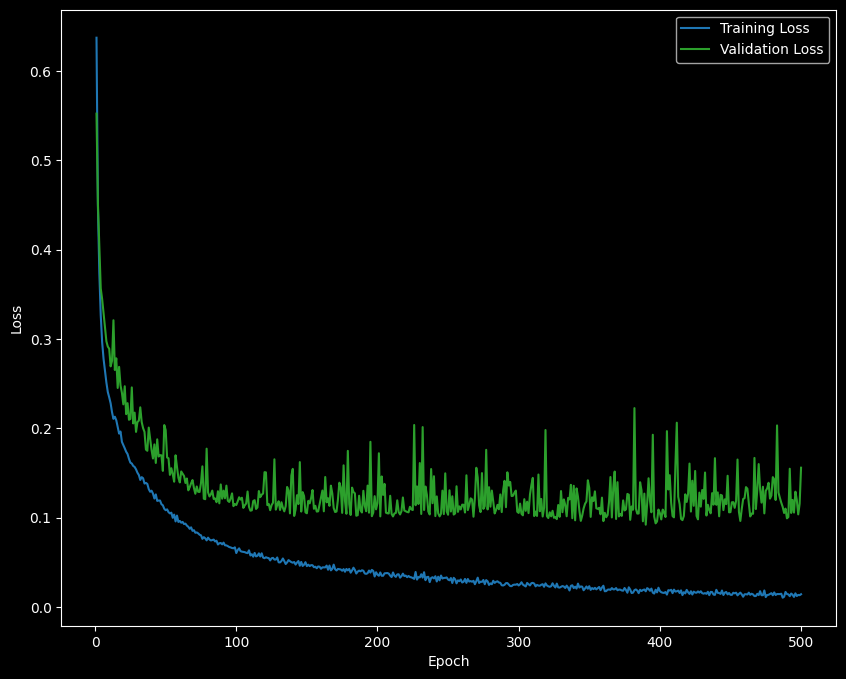

In [ ]:
# plotting the losses
from matplotlib import pyplot as plt

plt.style.use("dark_background")

plt.figure(figsize=(10, 8))

plt.plot(np.arange(1,end_epoch+1,1),
         history.history["loss"], color="tab:blue", label="Training Loss")
plt.plot(np.arange(1,end_epoch+1,1),
         history.history["val_loss"], color="tab:green", label="Validation Loss")

plt.legend()

plt.xlabel("Epoch")
plt.ylabel("Loss")

In [ ]:
# Early Stopping for our final model
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

model = create_model()

# Compile the model. Since we have one-hot encoded classes we use the categorical crossentropy
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

# model summary
model.summary()

# The training won't take long. Let's exceed the number of epochs
end_epoch = 500
batch_size = 32

history = model.fit(X_train, y_train,
                    epochs=end_epoch,
                    batch_size=batch_size,
                    verbose=0,
                    validation_split=0.25,
                    sample_weight=sample_weight,
                    callbacks=[es_callback])

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 49)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_1 (Normalization) │ (None, 49)             │            99 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 25)             │         1,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │           260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │            44 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,653 (6.46 KB)

 Trainable params: 1,554 (6.07 KB)

 Non-trainable params: 99 (400.00 B)

In [ ]:
# Compute class probabilities
y_test_prop_pred = model.predict(X_test)
print(y_test_prop_pred)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[[5.2596448e-08 5.8265156e-01 4.1698506e-01 3.6324101e-04]
 [2.0101319e-07 5.0599787e-02 9.4939572e-01 4.2956431e-06]
 [4.9965596e-09 1.0154189e-01 8.9845252e-01 5.6771541e-06]
 ...
 [7.7667861e-10 9.1485506e-01 8.3950154e-02 1.1947483e-03]
 [9.9983621e-01 9.9766289e-12 7.4038349e-17 1.6374441e-04]
 [6.4909332e-06 8.0806911e-01 1.6734916e-01 2.4575232e-02]]


In [ ]:
# Compute the corresponding one-hot classes
y_test_oh_pred = np.zeros_like(y_test_prop_pred)
y_test_oh_pred[np.arange(len(y_test_prop_pred)), y_test_prop_pred.argmax(1)] = 1
print(y_test_oh_pred)

[[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 ...
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]]


In [ ]:
# Re-transform the classes
asteroid_classes_test = label_encoder.inverse_transform(y_test).reshape(1, -1)[0]
asteroid_classes_test_pred = label_encoder.inverse_transform(y_test_oh_pred).reshape(1, -1)[0]

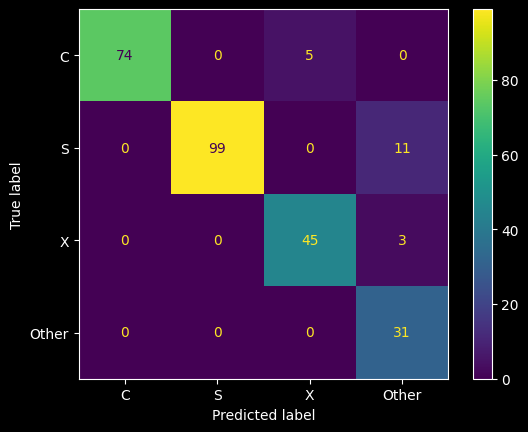

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Compute the confusion matrix
conf_mat = confusion_matrix(asteroid_classes_test,
                            asteroid_classes_test_pred,
                            labels=["C", "S", "X", "Other"])

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                              display_labels=["C", "S", "X", "Other"])
disp.plot()
plt.show()

In [ ]:
# A combined score
f1_score = round(sklearn.metrics.f1_score(asteroid_classes_test, asteroid_classes_test_pred, average="weighted"), 3)
print(f"F1 Score: {f1_score}")

F1 Score: 0.933
